## Initialization

In [1]:
import torch, argparse
import numpy as np

import os, sys

# sys.path.append(os.path.abspath(os.path.join('..')))

THIS_DIR = os.path.abspath(os.path.join('.'))
PARENT_DIR = os.path.dirname(THIS_DIR)
sys.path.append(PARENT_DIR)

from nn_models import MLP
from hnn import HNN
from utils import L2_loss, rk4
from data import get_dataset

print(THIS_DIR)
print(PARENT_DIR)

/Users/ZongyuWu/hamiltonian-nn/experiment-spring
/Users/ZongyuWu/hamiltonian-nn


## Help Functions

In [2]:
# print squared loss at specific steps for comparison with HNN
print_every = 200
def print_results(results, print_every=200):
    for step in range(0, len(results["train_loss"]), print_every):
        print(
            "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                step,
                results["train_loss"][step],
                results["test_loss"][step],
            )
        )
    # print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
    #     .format(results["train_loss"][-1], results["train_std"][-1],
    #             results["test_loss"][-1], results["test_std"][-1]))

def print_best(results):
    curr_min = 0

    for step in range(0, len(results["train_loss"])):
        if results["test_loss"][step] < results["test_loss"][curr_min]:
            curr_min = step
    print(
        "best test loss at step {}, train_loss {:.4e}, test_loss {:.4e}".format(
            curr_min,
            results["train_loss"][curr_min],
            results["test_loss"][curr_min],
        )
    )

In [3]:
def get_args():
    
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument(
        "--input_dim", default=2, type=int, help="dimensionality of input tensor"
    )
    parser.add_argument(
        "--hidden_dim", default=200, type=int, help="hidden dimension of mlp"
    )
    parser.add_argument("--learn_rate", default=1e-3, type=float, help="learning rate")
    parser.add_argument(
        "--nonlinearity", default="tanh", type=str, help="neural net nonlinearity"
    )
    parser.add_argument(
        "--total_steps", default=2000, type=int, help="number of gradient steps"
    )
    parser.add_argument(
        "--print_every",
        default=200,
        type=int,
        help="number of gradient steps between prints",
    )
    parser.add_argument(
        "--name", default="spring", type=str, help="only one option right now"
    )
    parser.add_argument(
        "--baseline",
        dest="baseline",
        action="store_true",
        help="run baseline or experiment?",
    )
    parser.add_argument(
        "--use_rk4",
        dest="use_rk4",
        action="store_true",
        help="integrate derivative with RK4",
    )
    parser.add_argument(
        "--verbose", dest="verbose", action="store_true", help="verbose?"
    )
    parser.add_argument(
        "--kan", dest="kan", action="store_true", help="use kan instead of mlp?"
    )
    parser.add_argument(
        "--field_type",
        default="solenoidal",
        type=str,
        help="type of vector field to learn",
    )
    parser.add_argument("--seed", default=0, type=int, help="random seed")
    parser.add_argument(
        "--save_dir", default=THIS_DIR, type=str, help="where to save the trained model"
    )
    parser.set_defaults(feature=True)
    
    args, unknown = parser.parse_known_args()  # <--- key difference
    return args

In [9]:
def train(args, denoise=True):
    # set random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)

    # init model and optimizer
    if args.verbose:
        print("Training baseline model:" if args.baseline else "Training HNN model:")

    output_dim = args.input_dim if args.baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(
        args.input_dim,
        differentiable_model=nn_model,
        field_type=args.field_type,
        baseline=args.baseline,
    )
    optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=1e-4)

    # arrange data
    data = get_dataset(keep_frequency=0.05, seed=args.seed, denoise=denoise, noise_std=2)
    x = torch.tensor(data["x"], requires_grad=True, dtype=torch.float32)
    test_x = torch.tensor(data["test_x"], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data["dx"])
    test_dxdt = torch.Tensor(data["test_dx"])

    # vanilla train loop
    stats = {"train_loss": [], "test_loss": []}
    for step in range(args.total_steps + 1):

        # train step
        dxdt_hat = (
            model.rk4_time_derivative(x) if args.use_rk4 else model.time_derivative(x)
        )
        loss = L2_loss(dxdt, dxdt_hat)
        loss.backward()
        optim.step()
        optim.zero_grad()

        # run test data
        test_dxdt_hat = (
            model.rk4_time_derivative(test_x)
            if args.use_rk4
            else model.time_derivative(test_x)
        )
        test_loss = L2_loss(test_dxdt, test_dxdt_hat)

        # logging
        stats["train_loss"].append(loss.item())
        stats["test_loss"].append(test_loss.item())
        if args.verbose and step % args.print_every == 0:
            print(
                "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                    step, loss.item(), test_loss.item()
                )
            )

    train_dxdt_hat = model.time_derivative(x)
    train_dist = (dxdt - train_dxdt_hat) ** 2
    test_dxdt_hat = model.time_derivative(test_x)
    test_dist = (test_dxdt - test_dxdt_hat) ** 2
    print(
        "Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}".format(
            train_dist.mean().item(),
            train_dist.std().item() / np.sqrt(train_dist.shape[0]),
            test_dist.mean().item(),
            test_dist.std().item() / np.sqrt(test_dist.shape[0]),
        )
    )

    return model, stats

## Create Dataset

/Users/ZongyuWu/miniforge3/envs/KARHNN/lib/python3.13/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `keep_frequency`, `alpha`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


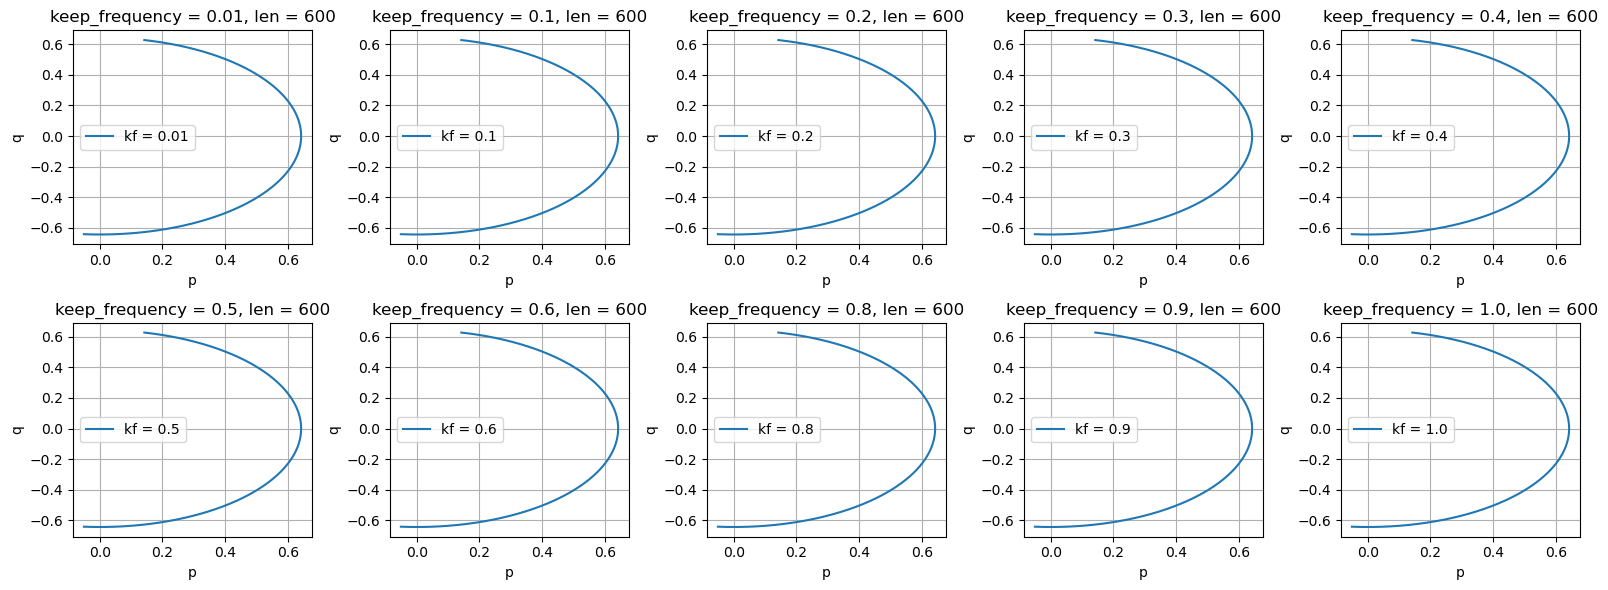

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from data import get_dataset
# Define the keep_frequency values you want to test
keep_freqs = [0.01, 0.1 ,0.2, 0.3, 0.4, 0.5,
              0.6, 0.8, 0.9, 1.0]

# Prepare the figure and axes: 2 rows, 5 columns = 10 subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))

for i, kf in enumerate(keep_freqs):
    # Get the dataset for this keep_frequency
    data = get_dataset( samples = 1, timescale = 400,seed=0, noise_std=2, keep_frequency=kf,alpha = 1 )

    # Convert to PyTorch if needed
    x_torch = torch.tensor(data["x"], dtype=torch.float32)

    # Extract p and q from the dataset (on CPU for plotting)
    p = x_torch[:, 0].detach().cpu().numpy()
    q = x_torch[:, 1].detach().cpu().numpy()

    # Determine the row & column for this subplot
    row, col = divmod(i, 5)

    # Plot the (p,q) path
    axs[row, col].plot(p, q, label=f'kf = {kf}')
    axs[row, col].set_title(f'keep_frequency = {kf}, len = {len(p)}')
    axs[row, col].set_xlabel('p')
    axs[row, col].set_ylabel('q')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# REPLACE THESE WITH YOUR ACTUAL IMPLEMENTATIONS OR IMPORTS
# --------------------------------------------------------------------
# The following are placeholders for illustration only.
# In your real code, these come from your existing project:
#
#   - get_args()      -> returns argparse Namespace or similar
#   - HNN, MLP        -> your model classes
#   - L2_loss         -> your L2 loss function
#   - get_dataset(...) -> loads data with the specified keep_frequency
#   - etc.





# --------------------------------------------------------------------
# END PLACEHOLDERS
# --------------------------------------------------------------------


def train_for_keepfreq(args, keep_frequency):
    """
    Train the HNN using the given keep_frequency for data filtering.
    Returns the trained model and training stats.
    """
    # 1) Set random seeds
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)

    # 2) Init model & optimizer
    if args.verbose:
        msg = "Training baseline model:" if args.baseline else "Training HNN model:"
        print(f"{msg}  keep_frequency = {keep_frequency:.2f}")
    output_dim = args.input_dim if args.baseline else 2

    nn_model = MLP(
        args.input_dim,
        args.hidden_dim,
        output_dim,
        args.nonlinearity
    )
    model = HNN(
        args.input_dim,
        differentiable_model=nn_model,
        field_type=args.field_type,
        baseline=args.baseline
    )
    optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=1e-4)

    # 3) Get data with the specified keep_frequency
    data = get_dataset(timescale=100, keep_frequency=keep_frequency, seed=args.seed)
    x = torch.tensor(data["x"], requires_grad=True, dtype=torch.float32)
    dxdt = torch.tensor(data["dx"], dtype=torch.float32)
    test_x = torch.tensor(data["test_x"], requires_grad=True, dtype=torch.float32)
    test_dxdt = torch.tensor(data["test_dx"], dtype=torch.float32)

    # 4) Training Loop
    stats = {"train_loss": [], "test_loss": []}
    for step in range(args.total_steps + 1):
        # forward pass on train data
        if args.use_rk4:
            dxdt_hat = model.rk4_time_derivative(x)
        else:
            dxdt_hat = model.time_derivative(x)
        loss = L2_loss(dxdt, dxdt_hat)

        # backward + optimize
        loss.backward()
        optim.step()
        optim.zero_grad()

        # forward pass on test data
        if args.use_rk4:
            test_dxdt_hat = model.rk4_time_derivative(test_x)
        else:
            test_dxdt_hat = model.time_derivative(test_x)
        test_loss = L2_loss(test_dxdt, test_dxdt_hat)

        # record metrics
        stats["train_loss"].append(loss.item())
        stats["test_loss"].append(test_loss.item())

        if args.verbose and step % args.print_every == 0:
            print(
                f"step {step:4d}, train_loss {loss.item():.4e}, test_loss {test_loss.item():.4e}"
            )

    # 5) Final logging
    train_dxdt_hat = model.time_derivative(x)
    train_dist = (dxdt - train_dxdt_hat) ** 2
    test_dxdt_hat = model.time_derivative(test_x)
    test_dist = (test_dxdt - test_dxdt_hat) ** 2
    print(
        "Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}".format(
            train_dist.mean().item(),
            train_dist.std().item() / np.sqrt(train_dist.shape[0]),
            test_dist.mean().item(),
            test_dist.std().item() / np.sqrt(test_dist.shape[0]),
        )
    )

    return model, stats


def train_multiple_keepfreqs(args, keep_freqs):
    """
    Main driver function that trains an HNN with the same random seed
    across different keep_frequency values. Saves or returns the results.
    """
    # Make save directory if needed
    os.makedirs(args.save_dir, exist_ok=True)

    results = {}
    for kf in keep_freqs:
        print(f"\n=== Training with keep_frequency = {kf:.2f} ===")
        model_kf, stats_kf = train_for_keepfreq(args, keep_frequency=kf)

        # Save the model for this keep_frequency
        label = f"_kf{kf:.2f}"
        path = os.path.join(args.save_dir, f"{args.name}{label}.tar")
        torch.save(model_kf.state_dict(), path)

        # Store stats in a dictionary for later analysis
        results[kf] = {
            "model": model_kf,
            "stats": stats_kf
        }
    return results


if __name__ == "__main__":
    # 1) Get command-line or predefined arguments
    args = get_args()
    args.verbose = True
    args.total_steps = 2000
    args.print_every = 500

    # 2) Define the list of keep_frequencies you want to test
    keep_freqs =  [0.01, 0.05,0.1 ,0.2, 0.3, 0.4, 0.5]

    # 3) Train for each keep_frequency
    all_results = train_multiple_keepfreqs(args, keep_freqs)

    # 4) (Optional) Analyze or plot the results
    # e.g., compare final train/test losses across keep_freqs
    for kf, res in all_results.items():
        final_train_loss = res["stats"]["train_loss"][-1]
        final_test_loss  = res["stats"]["test_loss"][-1]
        print(f"kf={kf:.2f} => Train: {final_train_loss:.4e}, Test: {final_test_loss:.4e}")



=== Training with keep_frequency = 0.01 ===
Training HNN model:  keep_frequency = 0.01
step    0, train_loss 6.7963e-01, test_loss 7.0194e-01
step  500, train_loss 6.7505e-01, test_loss 7.0172e-01
step 1000, train_loss 6.7506e-01, test_loss 7.0173e-01
step 1500, train_loss 6.7506e-01, test_loss 7.0174e-01
step 2000, train_loss 6.7506e-01, test_loss 7.0174e-01
Final train loss 6.7506e-01 +/- 1.0232e-02
Final test loss 7.0174e-01 +/- 1.0020e-02

=== Training with keep_frequency = 0.05 ===
Training HNN model:  keep_frequency = 0.05
step    0, train_loss 6.7940e-01, test_loss 6.9717e-01
step  500, train_loss 5.9930e-04, test_loss 6.5395e-04
step 1000, train_loss 4.8725e-04, test_loss 4.9397e-04
step 1500, train_loss 5.3301e-04, test_loss 6.7869e-04
step 2000, train_loss 4.1420e-04, test_loss 4.5080e-04
Final train loss 4.1420e-04 +/- 2.6930e-05
Final test loss 4.5080e-04 +/- 2.6072e-05

=== Training with keep_frequency = 0.10 ===
Training HNN model:  keep_frequency = 0.10
step    0, train

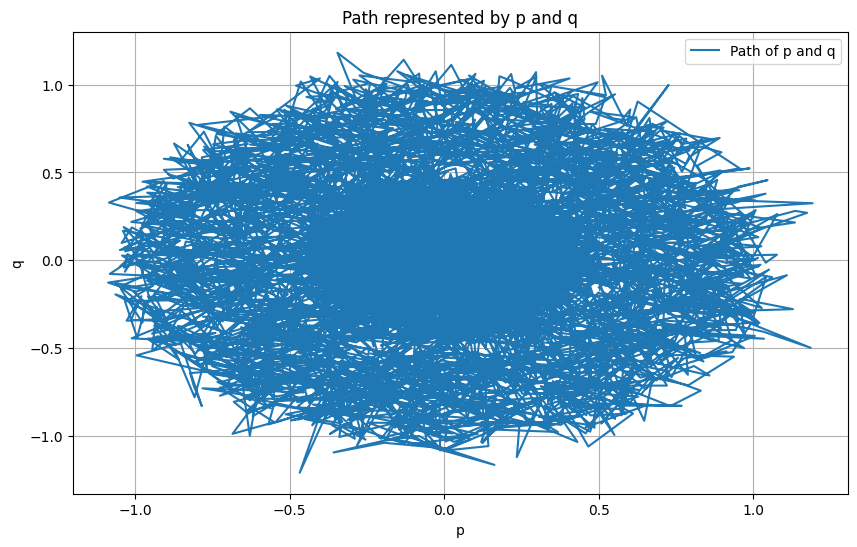

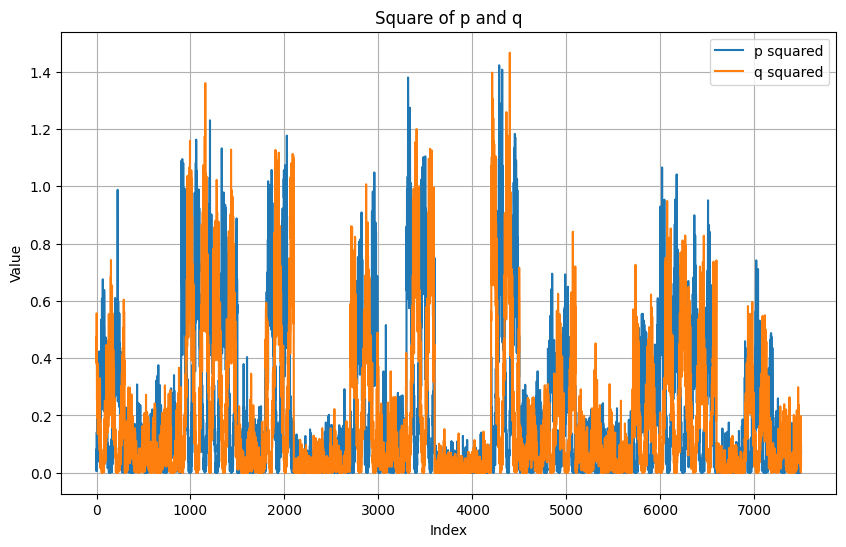

## Model Training

In [10]:
args = get_args()
# args.total_steps = 2000
args.verbose = True
model_denoise, stats_denoise = train(args, denoise=True)

# save
os.makedirs(args.save_dir) if not os.path.exists(args.save_dir) else None
label = '-denoise'
path = "{}/{}{}.tar".format(args.save_dir, args.name, label)
torch.save(model_denoise.state_dict(), path)

Training HNN model:
step 0, train_loss 6.8016e-01, test_loss 7.0005e-01
step 200, train_loss 1.2744e-03, test_loss 1.5111e-03
step 400, train_loss 1.3203e-03, test_loss 1.9043e-03
step 600, train_loss 1.0069e-03, test_loss 1.1848e-03
step 800, train_loss 9.7998e-04, test_loss 1.1626e-03
step 1000, train_loss 9.7184e-04, test_loss 1.1440e-03
step 1200, train_loss 9.6877e-04, test_loss 1.1623e-03
step 1400, train_loss 3.3566e-03, test_loss 4.5436e-03
step 1600, train_loss 9.5933e-04, test_loss 1.1334e-03
step 1800, train_loss 9.5213e-04, test_loss 1.1232e-03
step 2000, train_loss 2.6827e-03, test_loss 1.6968e-03
Final train loss 1.3550e-03 +/- 3.3660e-05
Final test loss 1.6968e-03 +/- 3.6323e-05


In [11]:
print_results(stats_denoise, 1)
print_best(stats_denoise)

step 0, train_loss 6.8016e-01, test_loss 7.0005e-01
step 1, train_loss 6.7420e-01, test_loss 6.9613e-01
step 2, train_loss 6.7056e-01, test_loss 6.8841e-01
step 3, train_loss 6.6268e-01, test_loss 6.8290e-01
step 4, train_loss 6.5692e-01, test_loss 6.7928e-01
step 5, train_loss 6.5320e-01, test_loss 6.7438e-01
step 6, train_loss 6.4844e-01, test_loss 6.6787e-01
step 7, train_loss 6.4224e-01, test_loss 6.6138e-01
step 8, train_loss 6.3618e-01, test_loss 6.5581e-01
step 9, train_loss 6.3104e-01, test_loss 6.5050e-01
step 10, train_loss 6.2608e-01, test_loss 6.4449e-01
step 11, train_loss 6.2030e-01, test_loss 6.3776e-01
step 12, train_loss 6.1370e-01, test_loss 6.3090e-01
step 13, train_loss 6.0691e-01, test_loss 6.2411e-01
step 14, train_loss 6.0022e-01, test_loss 6.1688e-01
step 15, train_loss 5.9319e-01, test_loss 6.0860e-01
step 16, train_loss 5.8522e-01, test_loss 5.9922e-01
step 17, train_loss 5.7627e-01, test_loss 5.8911e-01
step 18, train_loss 5.6668e-01, test_loss 5.7845e-01
ste

In [12]:
model_noise, stats_noise = train(args, denoise=False)

# save
os.makedirs(args.save_dir) if not os.path.exists(args.save_dir) else None
label = '-noise'
path = "{}/{}{}.tar".format(args.save_dir, args.name, label)
torch.save(model_noise.state_dict(), path)

Training HNN model:
step 0, train_loss 6.8016e-01, test_loss 7.0005e-01
step 200, train_loss 1.0022e-03, test_loss 1.2171e-03
step 400, train_loss 8.9395e-04, test_loss 1.2849e-03
step 600, train_loss 7.3245e-04, test_loss 8.6485e-04
step 800, train_loss 7.0341e-04, test_loss 8.5887e-04
step 1000, train_loss 6.9525e-04, test_loss 8.4684e-04
step 1200, train_loss 8.0261e-04, test_loss 9.2911e-04
step 1400, train_loss 6.8425e-04, test_loss 8.3568e-04
step 1600, train_loss 1.7697e-03, test_loss 8.4701e-04
step 1800, train_loss 6.7549e-04, test_loss 8.2713e-04
step 2000, train_loss 6.7112e-04, test_loss 8.2283e-04
Final train loss 6.7112e-04 +/- 1.0567e-05
Final test loss 8.2283e-04 +/- 1.2664e-05


In [13]:
print_results(stats_noise, 1)
print_best(stats_noise)

step 0, train_loss 6.8016e-01, test_loss 7.0005e-01
step 1, train_loss 6.7420e-01, test_loss 6.9613e-01
step 2, train_loss 6.7056e-01, test_loss 6.8840e-01
step 3, train_loss 6.6267e-01, test_loss 6.8289e-01
step 4, train_loss 6.5691e-01, test_loss 6.7926e-01
step 5, train_loss 6.5318e-01, test_loss 6.7436e-01
step 6, train_loss 6.4842e-01, test_loss 6.6784e-01
step 7, train_loss 6.4222e-01, test_loss 6.6135e-01
step 8, train_loss 6.3615e-01, test_loss 6.5577e-01
step 9, train_loss 6.3101e-01, test_loss 6.5046e-01
step 10, train_loss 6.2604e-01, test_loss 6.4445e-01
step 11, train_loss 6.2026e-01, test_loss 6.3772e-01
step 12, train_loss 6.1366e-01, test_loss 6.3085e-01
step 13, train_loss 6.0686e-01, test_loss 6.2405e-01
step 14, train_loss 6.0017e-01, test_loss 6.1682e-01
step 15, train_loss 5.9313e-01, test_loss 6.0853e-01
step 16, train_loss 5.8515e-01, test_loss 5.9914e-01
step 17, train_loss 5.7620e-01, test_loss 5.8903e-01
step 18, train_loss 5.6660e-01, test_loss 5.7836e-01
ste